# Time series clustering exercise

### Import necessary libraries

In [1]:
from __future__ import print_function
__author__ = "Gokmen Dedemen"
import numpy as np
import pandas as pd
import pylab as pl
import geopandas as gpd
from geopandas import GeoDataFrame
import wget
import os
import zipfile
import urllib
%pylab inline
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering


Populating the interactive namespace from numpy and matplotlib


# Data

## Download the census bureau business data for all years 1993-2014. 



In [2]:
for y in range(93, 100):
    if not os.path.isfile(os.getenv('PUIDATA') +"/zbp{}totals.zip".format(y)):
        os.system('curl -O ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp{}totals.zip'.format(y))
        os.system('mv zbp{}totals.zip '.format(y) + os.getenv("PUIDATA")) 

In [3]:
for y in range(0, 2):
    if not os.path.isfile(os.getenv('PUIDATA') +"/zbp0{}totals.zip".format(y)):
        os.system('curl -O ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp0{}totals.zip'.format(y))
        os.system('mv zbp0{}totals.zip '.format(y) + os.getenv("PUIDATA")) 

In [4]:
for y in range(2, 10):
    if not os.path.isfile(os.getenv('PUIDATA') +"/zbp0{}totals.zip".format(y)):
        os.system('curl -O ftp://ftp.census.gov/econ200{}/CBP_CSV/zbp0{}totals.zip'.format(y,y))
        os.system('mv zbp0{}totals.zip '.format(y) + os.getenv("PUIDATA")) 


In [5]:
for y in range(10, 15):
    if not os.path.isfile(os.getenv('PUIDATA') +"/zbp{}totals.zip".format(y)):
        os.system('curl -O ftp://ftp.census.gov/econ20{}/CBP_CSV/zbp{}totals.zip'.format(y,y))
        os.system('mv zbp{}totals.zip '.format(y) + os.getenv("PUIDATA")) 


## Below I am storing the filenames that start with zb and end with .zip

In [6]:
filenames = []
for i,file in enumerate(os.listdir(os.getenv("PUIDATA"))):
    if file.startswith("zb") and file.endswith(".zip"):
        filenames.append(file)

In [7]:
filenames

['zbp00totals.zip',
 'zbp01totals.zip',
 'zbp02totals.zip',
 'zbp03totals.zip',
 'zbp04totals.zip',
 'zbp05totals.zip',
 'zbp06totals.zip',
 'zbp07totals.zip',
 'zbp08totals.zip',
 'zbp09totals.zip',
 'zbp10totals.zip',
 'zbp11totals.zip',
 'zbp12totals.zip',
 'zbp13totals.zip',
 'zbp14totals.zip',
 'zbp94totals.zip',
 'zbp95totals.zip',
 'zbp96totals.zip',
 'zbp97totals.zip',
 'zbp98totals.zip',
 'zbp99totals.zip']

## the files should be unzipped, read and concatenated. Below I am unzippind and reading the first file "filenames[0]

In [8]:
zf = zipfile.ZipFile(os.getenv('PUIDATA') + '/' + filenames[0])
df = pd.read_csv(zf.open(filenames[0].replace('.zip','.txt')))
df.rename(columns={ 'ZIP': 'zip', 'EST': '2000'}, inplace = True)
df.head()

,zip,NAME,EMPFLAG,EMP,QP1,AP,2000
0,501,"HOLTSVILLE, NY",A,0,0,0,1
1,1001,"AGAWAM, MA",NaN,8042,59833,259661,493
2,1002,"AMHERST, MA",NaN,6547,36719,169658,563
3,1003,"AMHERST, MA",NaN,82,308,2482,13
4,1004,"AMHERST, MA",NaN,717,2049,5826,48


## Then I am merging the first file with the other files(That's why the range is 1 to len(filenames)) to the first file (df) in a for loop below. 

## Also, I am changing the column name EST with the corresponding years 

In [9]:
for i in range(1, len(filenames)):
    zf = zipfile.ZipFile(os.getenv('PUIDATA') + '/' + filenames[i])
    df_temp = pd.read_csv(zf.open(filenames[i].replace('.zip','.txt')))

    if (int(filenames [i] [3:5]) > 14):
        df_temp.rename(columns={ 'ZIP': 'zip', 'EST': '19{}'.format(filenames[i] [3:5]), 
                                 'est': '19{}'.format(filenames[i] [3:5])}, inplace=True)
        
        df = df.merge(df_temp[['zip','19{}'.format(filenames[i] [3:5])]], on = 'zip')


    else:
        df_temp.rename(columns={ 'ZIP': 'zip', 'EST': '20{}'.format(filenames[i] [3:5]), 
                                 'est': '20{}'.format(filenames[i] [3:5])}, inplace=True)
        df = df.merge(df_temp[['zip','20{}'.format(filenames[i] [3:5])]], on = 'zip')
        
        
df.head()
    

,zip,NAME,EMPFLAG,EMP,QP1,AP,2000,2001,2002,2003,...,2011,2012,2013,2014,1994,1995,1996,1997,1998,1999
0,1001,"AGAWAM, MA",NaN,8042,59833,259661,493,490,490,505,...,436,453,439,458,439,439,433,457,444,469
1,1002,"AMHERST, MA",NaN,6547,36719,169658,563,587,566,586,...,558,572,572,560,450,467,487,500,490,558
2,1003,"AMHERST, MA",NaN,82,308,2482,13,13,15,16,...,16,15,15,18,10,10,13,15,14,13
3,1004,"AMHERST, MA",NaN,717,2049,5826,48,37,23,21,...,19,16,16,13,47,48,47,41,31,35
4,1005,"BARRE, MA",NaN,764,4470,20413,86,90,94,93,...,91,94,97,97,92,95,101,104,95,82


## Below, I am reading the NYC zipcodes shape file from the url: https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip

In [10]:
url_shape = 'https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip'
urllib.request.urlretrieve(url_shape, 'shape_file.zip')
os.system("mv shape_file.zip" + os.getenv("PUIDATA"))
os.system("unzip "+ os.getenv("PUIDATA") + "/shape_file.zip -d " + os.getenv("PUIDATA"))

2304

## Let's see the files associated with the shape file, we are looking for the file with .shp extension

In [11]:
for i,file in enumerate(os.listdir(os.getenv("PUIDATA"))):
    if file.startswith("ZIP_CODE"):
        print(file)

ZIP_CODE_040114.dbf
ZIP_CODE_040114.prj
ZIP_CODE_040114.sbn
ZIP_CODE_040114.sbx
ZIP_CODE_040114.shp
ZIP_CODE_040114.shp.xml
ZIP_CODE_040114.shx


In [12]:
zip_shp = gpd.GeoDataFrame.from_file(os.getenv('PUIDATA') + '/' + 'ZIP_CODE_040114.shp')

In [13]:
zip_shp.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [14]:
zip_shp.rename(columns={'ZIPCODE': 'zip'}, inplace = True)
zip_shp['zip'] = zip_shp['zip'].astype(int)
df_zip = df.merge(zip_shp[['zip', 'geometry']], on = 'zip')
df_zip.head()

,zip,NAME,EMPFLAG,EMP,QP1,AP,2000,2001,2002,2003,...,2012,2013,2014,1994,1995,1996,1997,1998,1999,geometry
0,10001,"NEW YORK, NY",NaN,124661,1608935,5568152,7317,7188,7141,7084,...,7235,7273,7369,6999,7088,7075,7154,7254,7233,"POLYGON ((981958.6472873986 213464.4530421346,..."
1,10002,"NEW YORK, NY",NaN,19185,91736,386460,2277,2543,2269,2402,...,2954,2988,2972,1784,1819,1919,2049,2003,2085,"POLYGON ((991339.8703228086 207576.7837151289,..."
2,10003,"NEW YORK, NY",NaN,66250,688955,3055233,3683,3602,3616,3704,...,4214,4277,4333,3256,3377,3417,3535,3649,3659,"POLYGON ((989830.469142139 207048.1263078749, ..."
3,10004,"NEW YORK, NY",NaN,51582,2331796,7022508,1294,1247,1253,1252,...,1442,1479,1554,1115,1124,1133,1173,1176,1233,"POLYGON ((981197.408652395 196571.0816452205, ..."
4,10004,"NEW YORK, NY",NaN,51582,2331796,7022508,1294,1247,1253,1252,...,1442,1479,1554,1115,1124,1133,1173,1176,1233,"POLYGON ((972696.8446168154 193014.5477478057,..."


In [15]:
df_zip.drop(['NAME','EMPFLAG', 'EMP', 'QP1', 'AP'], axis = 1, inplace =True)
#df_zip.drop(['NAME'], axis = 1, inplace = True) 

In [16]:
df_zip.head()

,zip,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2012,2013,2014,1994,1995,1996,1997,1998,1999,geometry
0,10001,7317,7188,7141,7084,7370,7312,7415,7549,7472,...,7235,7273,7369,6999,7088,7075,7154,7254,7233,"POLYGON ((981958.6472873986 213464.4530421346,..."
1,10002,2277,2543,2269,2402,2551,2682,2686,2685,2691,...,2954,2988,2972,1784,1819,1919,2049,2003,2085,"POLYGON ((991339.8703228086 207576.7837151289,..."
2,10003,3683,3602,3616,3704,3776,3867,3909,4049,4071,...,4214,4277,4333,3256,3377,3417,3535,3649,3659,"POLYGON ((989830.469142139 207048.1263078749, ..."
3,10004,1294,1247,1253,1252,1283,1260,1311,1370,1376,...,1442,1479,1554,1115,1124,1133,1173,1176,1233,"POLYGON ((981197.408652395 196571.0816452205, ..."
4,10004,1294,1247,1253,1252,1283,1260,1311,1370,1376,...,1442,1479,1554,1115,1124,1133,1173,1176,1233,"POLYGON ((972696.8446168154 193014.5477478057,..."


# TASKS

## 1. get and prep your data.

In [17]:
df_zip.shape

(243, 23)

## Below, df_zip_cut dataframe only contains columns that are going to be normalized. 
## the geometry and the zip will not be normalized, so I am dividing the main dataset into two datasets

In [18]:
df_zip_cut = df_zip.drop(['zip', 'geometry'], axis =1)
df_zip_cut.head()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,1994,1995,1996,1997,1998,1999
0,7317,7188,7141,7084,7370,7312,7415,7549,7472,7305,...,7227,7235,7273,7369,6999,7088,7075,7154,7254,7233
1,2277,2543,2269,2402,2551,2682,2686,2685,2691,2775,...,2912,2954,2988,2972,1784,1819,1919,2049,2003,2085
2,3683,3602,3616,3704,3776,3867,3909,4049,4071,4099,...,4159,4214,4277,4333,3256,3377,3417,3535,3649,3659
3,1294,1247,1253,1252,1283,1260,1311,1370,1376,1379,...,1404,1442,1479,1554,1115,1124,1133,1173,1176,1233
4,1294,1247,1253,1252,1283,1260,1311,1370,1376,1379,...,1404,1442,1479,1554,1115,1124,1133,1173,1176,1233


In [19]:
df_zip_cut2 = df_zip[['zip', 'geometry']]
df_zip_cut2.head()

,zip,geometry
0,10001,"POLYGON ((981958.6472873986 213464.4530421346,..."
1,10002,"POLYGON ((991339.8703228086 207576.7837151289,..."
2,10003,"POLYGON ((989830.469142139 207048.1263078749, ..."
3,10004,"POLYGON ((981197.408652395 196571.0816452205, ..."
4,10004,"POLYGON ((972696.8446168154 193014.5477478057,..."


In [20]:
df_zip_standard = (df_zip_cut - df_zip_cut.mean()) / df_zip_cut.std()


In [21]:
df_zip_standard.describe()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,1994,1995,1996,1997,1998,1999
count,2.430000e+02,2.430000e+02,2.430000e+02,2.430000e+02,2.430000e+02,2.430000e+02,2.430000e+02,2.430000e+02,2.430000e+02,2.430000e+02,...,2.430000e+02,2.430000e+02,2.430000e+02,2.430000e+02,2.430000e+02,2.430000e+02,2.430000e+02,2.430000e+02,2.430000e+02,2.430000e+02
mean,2.604227e-17,-6.396347e-17,1.224444e-16,3.563679e-17,-4.111937e-17,1.736151e-17,4.934325e-17,7.173046e-17,3.792120e-17,5.482583e-18,...,1.096517e-17,9.274703e-17,-2.695603e-17,-9.183326e-17,1.882353e-16,-6.304970e-17,8.223874e-17,-7.584240e-17,-4.934325e-17,-1.050828e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-7.003850e-01,-6.974477e-01,-7.271080e-01,-7.359248e-01,-7.300778e-01,-7.384998e-01,-7.379638e-01,-7.489794e-01,-7.563193e-01,-7.698527e-01,...,-7.864552e-01,-7.911997e-01,-7.977150e-01,-8.036458e-01,-6.872774e-01,-6.843201e-01,-6.906147e-01,-6.931385e-01,-6.953840e-01,-7.024405e-01
25%,-5.470370e-01,-5.475366e-01,-5.637176e-01,-5.662762e-01,-5.695566e-01,-5.844064e-01,-5.819766e-01,-6.009701e-01,-6.013060e-01,-6.019285e-01,...,-6.326813e-01,-6.401730e-01,-6.509691e-01,-6.621184e-01,-5.398239e-01,-5.330901e-01,-5.405986e-01,-5.445801e-01,-5.444322e-01,-5.509040e-01
50%,-3.050155e-01,-3.036271e-01,-2.925147e-01,-2.938355e-01,-2.976864e-01,-3.027875e-01,-3.008746e-01,-3.090631e-01,-3.085947e-01,-3.036752e-01,...,-2.918849e-01,-2.899721e-01,-2.873655e-01,-2.909124e-01,-3.048608e-01,-3.024002e-01,-3.027891e-01,-3.008776e-01,-2.991873e-01,-3.049677e-01
75%,7.164311e-02,6.912485e-02,9.569410e-02,9.226143e-02,9.081572e-02,1.047222e-01,8.746867e-02,1.061849e-01,1.172796e-01,1.249074e-01,...,1.386822e-01,1.585814e-01,1.761068e-01,1.935156e-01,9.593276e-02,8.635486e-02,1.063455e-01,9.013139e-02,8.791097e-02,8.670864e-02
max,5.248869e+00,5.123155e+00,5.236849e+00,5.180049e+00,5.255943e+00,5.236400e+00,5.283793e+00,5.455895e+00,5.402986e+00,5.331392e+00,...,5.219042e+00,5.160981e+00,5.128371e+00,5.152634e+00,5.436639e+00,5.370861e+00,5.338155e+00,5.275904e+00,5.302158e+00,5.285322e+00


## As can be seen above, the mean of each column is around 0, and standard deviation is exactly 1.

## Below, we can merge them again, the merge can be done with the left and right index this time.  

In [22]:
df = df_zip_cut2.merge(df_zip_standard, left_index = True, right_index = True)

In [23]:
df

,zip,geometry,2000,2001,2002,2003,2004,2005,2006,2007,...,2011,2012,2013,2014,1994,1995,1996,1997,1998,1999
0,10001,"POLYGON ((981958.6472873986 213464.4530421346,...",5.248869,5.123155,5.236849,5.180049,5.255943,5.236400,5.283793,5.455895,...,5.219042,5.160981,5.128371,5.152634,5.436639,5.370861,5.338155,5.275904,5.302158,5.285322
1,10002,"POLYGON ((991339.8703228086 207576.7837151289,...",1.148740,1.359171,1.165044,1.267266,1.339224,1.451507,1.441795,1.456358,...,1.632368,1.637573,1.635005,1.596658,0.873017,0.868991,0.943367,1.015283,0.958882,1.022426
2,10003,"POLYGON ((989830.469142139 207048.1263078749, ...",2.292546,2.217311,2.290808,2.355358,2.334862,2.420211,2.435402,2.577939,...,2.668887,2.674596,2.685868,2.697337,2.161157,2.200157,2.220208,2.255495,2.320343,2.325805
3,10004,"POLYGON ((981197.408652395 196571.0816452205, ...",0.349053,0.308983,0.315916,0.306203,0.308637,0.289062,0.324699,0.375068,...,0.378902,0.393146,0.404786,0.449882,0.287579,0.275179,0.273409,0.284175,0.274843,0.316912
4,10004,"POLYGON ((972696.8446168154 193014.5477478057,...",0.349053,0.308983,0.315916,0.306203,0.308637,0.289062,0.324699,0.375068,...,0.378902,0.393146,0.404786,0.449882,0.287579,0.275179,0.273409,0.284175,0.274843,0.316912
5,10004,"POLYGON ((977542.4500830621 188447.2783390433,...",0.349053,0.308983,0.315916,0.306203,0.308637,0.289062,0.324699,0.375068,...,0.378902,0.393146,0.404786,0.449882,0.287579,0.275179,0.273409,0.284175,0.274843,0.316912
6,10004,"POLYGON ((971218.3702115566 190710.8587856293,...",0.349053,0.308983,0.315916,0.306203,0.308637,0.289062,0.324699,0.375068,...,0.378902,0.393146,0.404786,0.449882,0.287579,0.275179,0.273409,0.284175,0.274843,0.316912
7,10005,"POLYGON ((982595.6794779003 195880.7536295503,...",0.343358,0.310603,0.308394,0.262746,0.262309,0.251458,0.282453,0.295308,...,0.293287,0.254053,0.255594,0.261449,0.253450,0.262363,0.344155,0.329244,0.352594,0.324364
8,10006,"POLYGON ((981136.3431577235 198082.3837407082,...",0.164384,0.129900,0.049310,-0.019723,-0.027848,-0.029752,-0.030334,-0.041824,...,-0.094888,-0.094090,-0.106379,-0.115418,0.240323,0.170941,0.133621,0.131444,0.154082,0.172828
9,10007,"POLYGON ((980538.9073447287 200658.5114624649,...",0.375899,0.297638,0.622638,0.599536,0.594731,0.330753,0.309263,0.304353,...,0.348978,0.358579,0.359947,0.366583,0.455597,0.403340,0.376545,0.379319,0.362519,0.374876


## 2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters 

##  3. plot the cluster centers 

## I am trying 3,5 and 8 clusters for k-means algorithm below. 

In [24]:
km_three = KMeans(n_clusters = 3)
km_five = KMeans(n_clusters = 5)
km_eight = KMeans(n_clusters = 8)


#centers_three = km_three.cluster_centers_
#centers_five = km_five.cluster_centers_
#centers_eight = km_eight.cluster_centers_

## Firstly, clustering is performed with three clusters (k =3)

/Users/gokmendedemen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  import sys


Text(0.5,0,'Year')

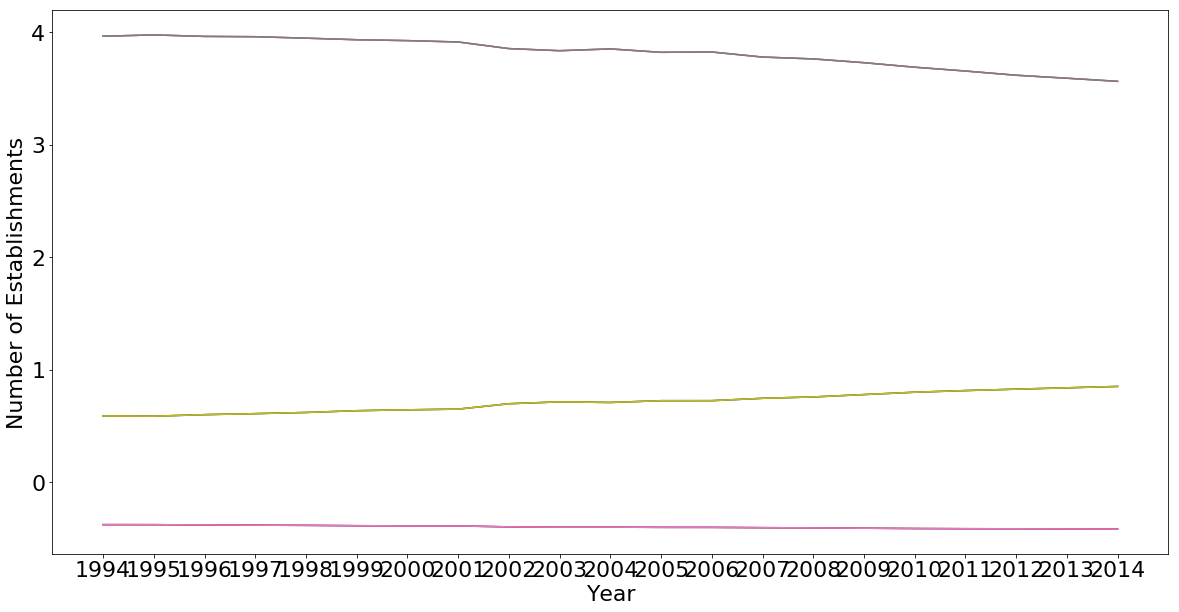

In [25]:
km_three.fit(df_zip_standard)
pl.figure(figsize=(20,10))
km_three.fit(df_zip_standard)
centers = km_three.cluster_centers_
labels = km_three.labels_
c3 = pd.DataFrame(centers, columns = df_zip_standard.columns)
c3 = c3.reindex_axis(sorted(c3.columns), axis=1)
matplotlib.rcParams.update({'font.size': 22})

for i in range(3):
    pl.plot(c3.T)
pl.ylabel("Number of Establishments", size ='22')
pl.xlabel("Year", size = '22')


**Figure 1**: The plot of cluster centers when k=3 

## Comment: Cluster centers are away from each other, this is a good property. 

## The same process is now repeated for the other cluster numbers

## when k = 5

/Users/gokmendedemen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  import sys


Text(0.5,0,'Year')

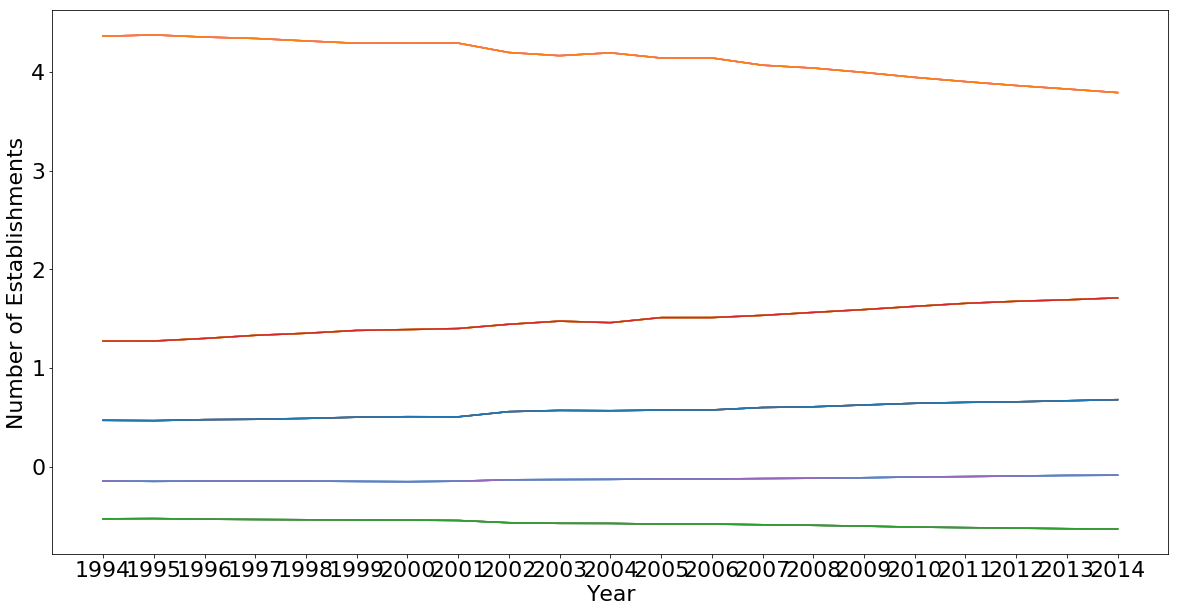

In [26]:
km_five.fit(df_zip_standard)
pl.figure(figsize=(20,10))
km_five.fit(df_zip_standard)
centers = km_five.cluster_centers_
df['kmeans_five']= km_five.labels_
c5 = pd.DataFrame(centers, columns = df_zip_standard.columns)
c5 = c5.reindex_axis(sorted(c5.columns), axis=1)
matplotlib.rcParams.update({'font.size': 22})

for i in range(5):
    pl.plot(c5.T)
    
pl.ylabel("Number of Establishments", size ='22')
pl.xlabel("Year", size = '22')

**Figure 2**: The plot of cluster centers when k=5 

## The distance between cluster centers for blue and purple clusters seems to be a little bit low. However, the other cluster centers are well-seperated.

## finally, when k = 8

/Users/gokmendedemen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  import sys


Text(0.5,0,'Year')

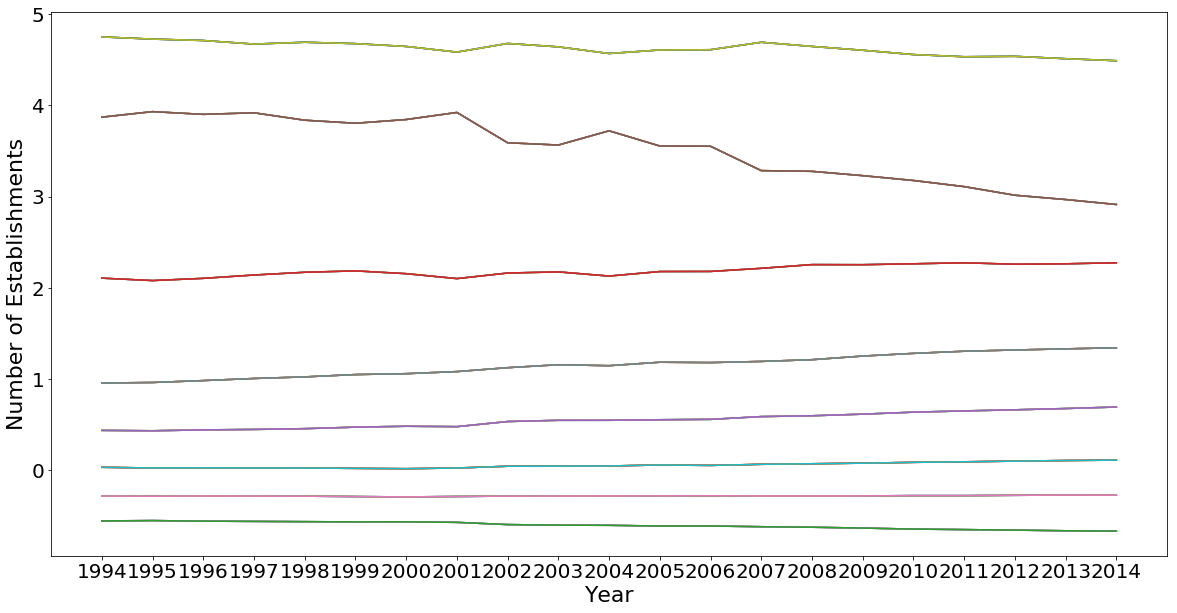

In [27]:
km_eight.fit(df_zip_standard)
pl.figure(figsize=(20,10))
km_eight.fit(df_zip_standard)
centers = km_eight.cluster_centers_
labels = km_eight.labels_
c8 = pd.DataFrame(centers, columns = df_zip_standard.columns)
c8 = c8.reindex_axis(sorted(c8.columns), axis=1)
matplotlib.rcParams.update({'font.size': 20})

for i in range(5):
    pl.plot(c8.T)
    
pl.ylabel("Number of Establishments", size ='22')
pl.xlabel("Year", size = '22')

**Figure 3**: The plot of cluster centers when k=8

##  Comment: The distance between cluster centers are really low. It seems to me that 8 clusters are way too many for this dataset

## 4. Use another clustering algorithm (of your choice)


## Performing Agglomarative Clustering with 5 clusters

In [28]:
a_c = AgglomerativeClustering(n_clusters=5, linkage="ward").fit(df_zip_standard)

## Create necessary columns in the dataframe for assigned cluster numbers

In [29]:
# we are using the dataset that we merged before here
df.head()

,zip,geometry,2000,2001,2002,2003,2004,2005,2006,2007,...,2012,2013,2014,1994,1995,1996,1997,1998,1999,kmeans_five
0,10001,"POLYGON ((981958.6472873986 213464.4530421346,...",5.248869,5.123155,5.236849,5.180049,5.255943,5.236400,5.283793,5.455895,...,5.160981,5.128371,5.152634,5.436639,5.370861,5.338155,5.275904,5.302158,5.285322,1
1,10002,"POLYGON ((991339.8703228086 207576.7837151289,...",1.148740,1.359171,1.165044,1.267266,1.339224,1.451507,1.441795,1.456358,...,1.637573,1.635005,1.596658,0.873017,0.868991,0.943367,1.015283,0.958882,1.022426,3
2,10003,"POLYGON ((989830.469142139 207048.1263078749, ...",2.292546,2.217311,2.290808,2.355358,2.334862,2.420211,2.435402,2.577939,...,2.674596,2.685868,2.697337,2.161157,2.200157,2.220208,2.255495,2.320343,2.325805,3
3,10004,"POLYGON ((981197.408652395 196571.0816452205, ...",0.349053,0.308983,0.315916,0.306203,0.308637,0.289062,0.324699,0.375068,...,0.393146,0.404786,0.449882,0.287579,0.275179,0.273409,0.284175,0.274843,0.316912,0
4,10004,"POLYGON ((972696.8446168154 193014.5477478057,...",0.349053,0.308983,0.315916,0.306203,0.308637,0.289062,0.324699,0.375068,...,0.393146,0.404786,0.449882,0.287579,0.275179,0.273409,0.284175,0.274843,0.316912,0


In [30]:
df['a_c'] = a_c.labels_

In [31]:
df.head()

,zip,geometry,2000,2001,2002,2003,2004,2005,2006,2007,...,2013,2014,1994,1995,1996,1997,1998,1999,kmeans_five,a_c
0,10001,"POLYGON ((981958.6472873986 213464.4530421346,...",5.248869,5.123155,5.236849,5.180049,5.255943,5.236400,5.283793,5.455895,...,5.128371,5.152634,5.436639,5.370861,5.338155,5.275904,5.302158,5.285322,1,0
1,10002,"POLYGON ((991339.8703228086 207576.7837151289,...",1.148740,1.359171,1.165044,1.267266,1.339224,1.451507,1.441795,1.456358,...,1.635005,1.596658,0.873017,0.868991,0.943367,1.015283,0.958882,1.022426,3,1
2,10003,"POLYGON ((989830.469142139 207048.1263078749, ...",2.292546,2.217311,2.290808,2.355358,2.334862,2.420211,2.435402,2.577939,...,2.685868,2.697337,2.161157,2.200157,2.220208,2.255495,2.320343,2.325805,3,4
3,10004,"POLYGON ((981197.408652395 196571.0816452205, ...",0.349053,0.308983,0.315916,0.306203,0.308637,0.289062,0.324699,0.375068,...,0.404786,0.449882,0.287579,0.275179,0.273409,0.284175,0.274843,0.316912,0,1
4,10004,"POLYGON ((972696.8446168154 193014.5477478057,...",0.349053,0.308983,0.315916,0.306203,0.308637,0.289062,0.324699,0.375068,...,0.404786,0.449882,0.287579,0.275179,0.273409,0.284175,0.274843,0.316912,0,1


# 5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters

# 6. Compare the results of the 2 algorithms

## I am comparing the results of k-means and agglomarative clustering both for number of clusters = 5.

In [32]:
df = gpd.GeoDataFrame(df)
df.head()

,zip,geometry,2000,2001,2002,2003,2004,2005,2006,2007,...,2013,2014,1994,1995,1996,1997,1998,1999,kmeans_five,a_c
0,10001,"POLYGON ((981958.6472873986 213464.4530421346,...",5.248869,5.123155,5.236849,5.180049,5.255943,5.236400,5.283793,5.455895,...,5.128371,5.152634,5.436639,5.370861,5.338155,5.275904,5.302158,5.285322,1,0
1,10002,"POLYGON ((991339.8703228086 207576.7837151289,...",1.148740,1.359171,1.165044,1.267266,1.339224,1.451507,1.441795,1.456358,...,1.635005,1.596658,0.873017,0.868991,0.943367,1.015283,0.958882,1.022426,3,1
2,10003,"POLYGON ((989830.469142139 207048.1263078749, ...",2.292546,2.217311,2.290808,2.355358,2.334862,2.420211,2.435402,2.577939,...,2.685868,2.697337,2.161157,2.200157,2.220208,2.255495,2.320343,2.325805,3,4
3,10004,"POLYGON ((981197.408652395 196571.0816452205, ...",0.349053,0.308983,0.315916,0.306203,0.308637,0.289062,0.324699,0.375068,...,0.404786,0.449882,0.287579,0.275179,0.273409,0.284175,0.274843,0.316912,0,1
4,10004,"POLYGON ((972696.8446168154 193014.5477478057,...",0.349053,0.308983,0.315916,0.306203,0.308637,0.289062,0.324699,0.375068,...,0.404786,0.449882,0.287579,0.275179,0.273409,0.284175,0.274843,0.316912,0,1


/Users/gokmendedemen/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:381: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


Text(0.5,1,'Agg Clustering with 5 clusters')

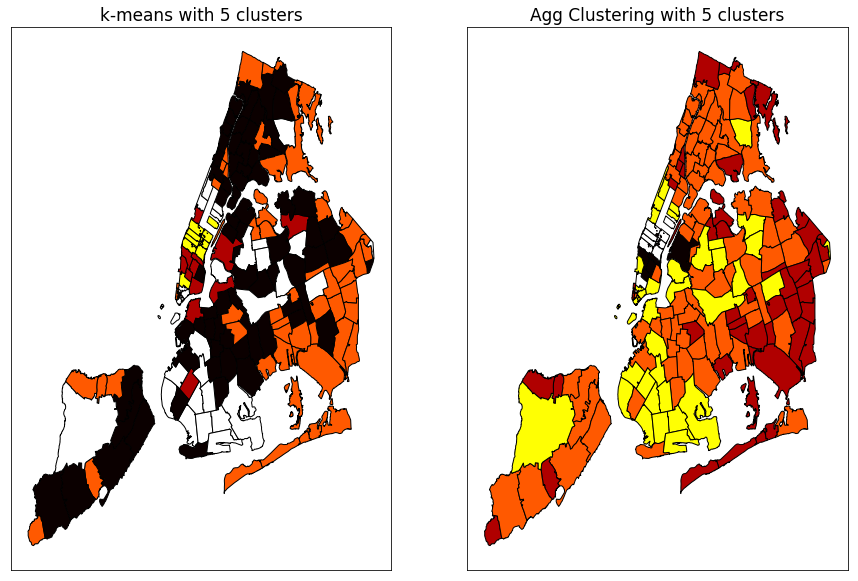

In [33]:
f, (ax1, ax2) = plt.subplots(1,2)
f.set_figheight(10)
f.set_figwidth(15)

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
df.plot(column = 'kmeans_five', colormap = 'hot_r', edgecolor = 'black', ax = ax1)

ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

df.plot(column = 'a_c', colormap = 'hot_r', edgecolor = 'black', ax = ax2)

ax1.set_title("k-means with 5 clusters", fontsize = 17)
ax2.set_title("Agg Clustering with 5 clusters", fontsize = 17)

**Figure 4**: Comparison of k-means and agglomarative clustering results for 5 clusters. 

## 7. attempt an interpretation.

## As we can see above, k-means and aglomarative clustering results are very similar. 

## ASH Score 100